In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [3]:
# %% [markdown]
# # Predicting Parkinson's Conversion in a Prodromal Cohort
# 
# **Objective:** To build a multimodal machine learning model that predicts which individuals in the PPMI prodromal cohort will convert to a full diagnosis of Parkinson's Disease within one year.
# 
# **Methodology:**
# 1.  **Data Integration:** Load and merge longitudinal cohort history, demographics, motor scores (UPDRS), non-motor scores (SCOPA-AUT), and imaging data.
# 2.  **Feature Engineering:** Isolate baseline features as predictors and the one-year conversion status as the target variable.
# 3.  **Modeling:** Train a RandomForest Classifier on the baseline data to predict the one-year outcome.
# 4.  **Evaluation & Interpretation:** Evaluate the model's performance and analyze feature importances to identify key predictors of conversion.

# %% [markdown]
# ## 1. Configuration
# 
# ✏️ **Action Required:** Update all filenames, folder paths, and column names in this cell to match your dataset.

# %%
# --- File Paths & Names ---
# Replace 'your-folder-name' with the actual folder name from your Kaggle input
COHORT_HISTORY_FILE = "/kaggle/input/datasets-2/Subject_Cohort_History_24Jul2025.csv"
DEMOGRAPHICS_FILE = "/kaggle/input/datasets-2/Screening___Demographics-Archived_24Jun2025 (1).csv"
UPDRS_FILE = "/kaggle/input/datasets-2/MDS-UPDRS_Part_III_24Jun2025.csv"
SCOPA_FILE = "/kaggle/input/datasets-2/SCOPA-AUT_24Jul2025.csv"
MRI_FILE = "/kaggle/input/datasets-2/MRIQC_24Jun2025 (1).csv"  # <-- IMPORTANT: Replace with your actual MRI data file name

# --- Load all data files ---
try:
    cohort_df = pd.read_csv(COHORT_HISTORY_FILE)
    demog_df = pd.read_csv(DEMOGRAPHICS_FILE)
    # Using low_memory=False to handle the DtypeWarning
    updrs_df = pd.read_csv(UPDRS_FILE, low_memory=False)
    scopa_df = pd.read_csv(SCOPA_FILE)
    
    print("All data files loaded successfully.")

except FileNotFoundError as e:
    print(f"File loading failed. Error: {e}")
    print("\nPlease ensure all filenames in the configuration section are correct.")
except Exception as e:
    print(f"An error occurred: {e}")


All data files loaded successfully.


In [4]:
print(demog_df.columns.tolist())

['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'SIGNCNST', 'CONSNTDT', 'APPRDX', 'CURRENT_APPRDX', 'P3GRP', 'BIRTHDT', 'GENDER', 'HISPLAT', 'RAINDALS', 'RAASIAN', 'RABLACK', 'RAHAWOPI', 'RAWHITE', 'RANOS', 'PRJENRDT', 'REFERRAL', 'DECLINED', 'RSNDEC', 'EXCLUDED', 'RSNEXC', 'ORIG_ENTRY', 'LAST_UPDATE', 'QUERY', 'SITE_APRV']


In [5]:
print(cohort_df.columns.tolist())

['PATNO', 'APPRDX', 'COHORT']


In [6]:
# --- Column Names (Update if needed) ---
PATIENT_ID_COL = 'PATNO'
DIAGNOSIS_COL = 'COHORT' # Or 'APPRDX' if it's more accurate
SEX_COL = 'GENDER'
BIRTH_DATE_COL = 'BIRTHDT'
BASELINE_VISIT_ID = 'BL'
# --- 2. Prepare Each Dataset ---
# Cohort/Diagnosis data (this file is treated as the master list of patient diagnoses)
diagnosis_data = cohort_df[[PATIENT_ID_COL, DIAGNOSIS_COL]].drop_duplicates(subset=PATIENT_ID_COL)

# Demographics data
demog_data = demog_df[[PATIENT_ID_COL, SEX_COL, BIRTH_DATE_COL]].copy()
demog_data.drop_duplicates(subset=PATIENT_ID_COL, inplace=True)
demog_data['AGE'] = 2023 - demog_data[BIRTH_DATE_COL] # Using a recent year
demog_data = demog_data[[PATIENT_ID_COL, 'AGE', SEX_COL]]

# UPDRS Motor Score at Baseline
updrs_bl = updrs_df[updrs_df['EVENT_ID'] == BASELINE_VISIT_ID].copy()
updrs_cols = [col for col in updrs_bl.columns if col.startswith('NP3')]
updrs_bl['UPDRS_III_TOTAL'] = updrs_bl[updrs_cols].sum(axis=1)
updrs_bl = updrs_bl[[PATIENT_ID_COL, 'UPDRS_III_TOTAL']]

# SCOPA-AUT Score at Baseline
scopa_bl = scopa_df[scopa_df['EVENT_ID'] == BASELINE_VISIT_ID].copy()
scopa_cols = [col for col in scopa_bl.columns if col.startswith('SCAU')]

# --- FIX: Convert all SCOPA columns to numeric, coercing errors ---
# This loop ensures any non-numeric data (like text) becomes NaN
for col in scopa_cols:
    scopa_bl[col] = pd.to_numeric(scopa_bl[col], errors='coerce')

# Now the sum will work, as it automatically skips NaN values
scopa_bl['SCOPA_TOTAL'] = scopa_bl[scopa_cols].sum(axis=1)
scopa_bl = scopa_bl[[PATIENT_ID_COL, 'SCOPA_TOTAL']]

# --- 3. Merge all Baseline Features with Diagnosis Data ---
print("\nMerging all datasets for cross-sectional analysis...")
final_df = pd.merge(diagnosis_data, demog_data, on=PATIENT_ID_COL, how='inner')
final_df = pd.merge(final_df, updrs_bl, on=PATIENT_ID_COL, how='inner')
final_df = pd.merge(final_df, scopa_bl, on=PATIENT_ID_COL, how='inner')

# --- 4. Display the Final DataFrame ---
print("\n--- Merge Complete ---")
print(f"Final merged dataframe has {final_df.shape[0]} rows and {final_df.shape[1]} columns.")
print("\nColumns and data types of the final dataframe:")
final_df.info()


Merging all datasets for cross-sectional analysis...

--- Merge Complete ---
Final merged dataframe has 1056 rows and 6 columns.

Columns and data types of the final dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PATNO            1056 non-null   int64  
 1   COHORT           1056 non-null   int64  
 2   AGE              1056 non-null   float64
 3   GENDER           1056 non-null   float64
 4   UPDRS_III_TOTAL  1056 non-null   float64
 5   SCOPA_TOTAL      1056 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 49.6 KB


Cohort labels present in the data:
COHORT
1    560
4    383
2    110
3      3
Name: count, dtype: int64

Training model on 943 participants...

--- Model Performance ---
Accuracy: 0.9280
AUC-ROC Score: 0.9778


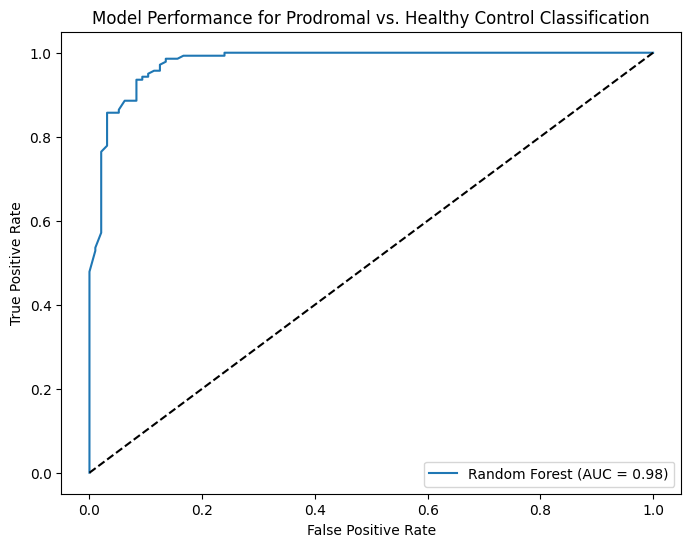

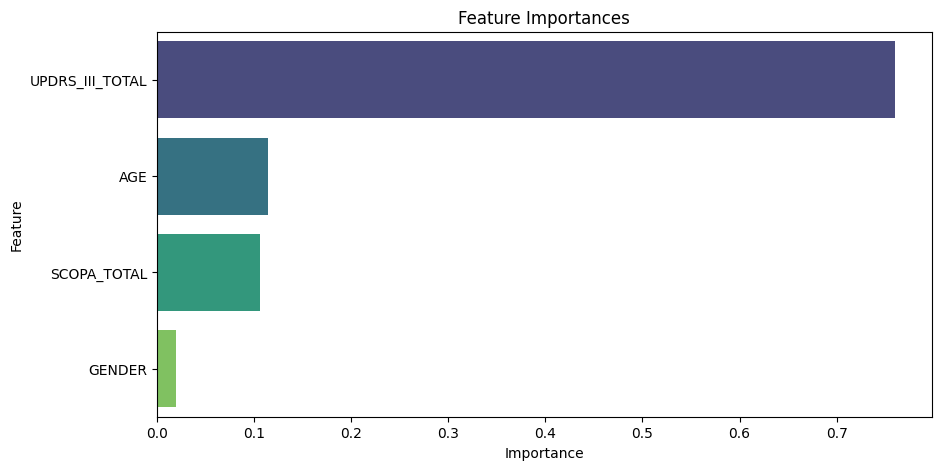


--- Key Predictors (from most to least important) ---
           Feature  Importance
2  UPDRS_III_TOTAL    0.760100
0              AGE    0.114324
3      SCOPA_TOTAL    0.105697
1           GENDER    0.019879


In [7]:


# This assumes 'final_df' is the dataframe from your previous step.
# You can run this code in a new cell.

# --- 1. Prepare Data for Modeling ---

# First, check the cohort labels in your data
print("Cohort labels present in the data:")
print(final_df['COHORT'].value_counts())

# ⚠️ Action Required: Update these labels to compare PD vs. Prodromal
PD_LABEL = 1
PRODROMAL_LABEL = 4

# Filter the dataframe to only include the two cohorts you want to compare
model_data = final_df[final_df['COHORT'].isin([PD_LABEL, PRODROMAL_LABEL])].copy()

# Create the binary target variable (y): 1 for PD, 0 for Prodromal
model_data['Target'] = model_data['COHORT'].map({PD_LABEL: 1, PRODROMAL_LABEL: 0})

# Define your features (X) and target (y)
features = ['AGE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL']
target = 'Target'

X = model_data[features]
y = model_data[target]

print(f"\nTraining model on {len(X)} participants...")

# --- 2. Train the Model ---

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForest model
# class_weight='balanced' is helpful if one group is larger than the other
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# --- 3. Evaluate Performance ---

# Make predictions and evaluate
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Performance for Prodromal vs. Healthy Control Classification')
plt.legend()
plt.show()

# --- 4. Analyze Feature Importance ---

# Extract and plot which features were most important for the prediction
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.show()

print("\n--- Key Predictors (from most to least important) ---")
print(feature_importance_df)

In [8]:
# This code assumes X_train, X_test, and y_train are available 
# from your data splitting step.

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train)
X_test_scaled_np = scaler.transform(X_test)

# --- FIX: Convert scaled arrays back to DataFrames with columns ---
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_test.columns)


# --- Now, the Late Fusion code will work correctly ---
print("--- Implementing Late Fusion ---")

# Define the feature groups for each modality
demog_features = ['AGE', 'GENDER']
motor_features = ['UPDRS_III_TOTAL']
non_motor_features = ['SCOPA_TOTAL']

# 1. Train a separate model for each feature group
model_demog = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced').fit(X_train_scaled[demog_features], y_train)
model_motor = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced').fit(X_train_scaled[motor_features], y_train)
model_non_motor = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced').fit(X_train_scaled[non_motor_features], y_train)

# 2. Get the predicted probabilities from each model
proba_demog = model_demog.predict_proba(X_test_scaled[demog_features])[:, 1]
proba_motor = model_motor.predict_proba(X_test_scaled[motor_features])[:, 1]
proba_non_motor = model_non_motor.predict_proba(X_test_scaled[non_motor_features])[:, 1]

# 3. Average the predictions
late_fusion_probas = (proba_demog + proba_motor + proba_non_motor) / 3

# 4. Evaluate the late fusion model
late_fusion_auc = roc_auc_score(y_test, late_fusion_probas)
print(f"Late Fusion AUC-ROC Score: {late_fusion_auc:.4f}")

--- Implementing Late Fusion ---
Late Fusion AUC-ROC Score: 0.9407


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# This code assumes X_train_scaled, X_test_scaled, y_train, and y_test exist.

print("--- Implementing Intermediate Fusion using a Neural Network ---")

# --- 1. Prepare Data for Multi-Input Model ---
# The neural network needs a separate input array for each data modality.

# Define feature groups
demog_features = ['AGE', 'GENDER']
motor_features = ['UPDRS_III_TOTAL']
non_motor_features = ['SCOPA_TOTAL']

# Create separate training arrays
X_train_demog = X_train_scaled[demog_features].values
X_train_motor = X_train_scaled[motor_features].values
X_train_non_motor = X_train_scaled[non_motor_features].values

# Create separate testing arrays
X_test_demog = X_test_scaled[demog_features].values
X_test_motor = X_test_scaled[motor_features].values
X_test_non_motor = X_test_scaled[non_motor_features].values


# --- 2. Define the Model Architecture ---

# Input layers for each modality
input_demog = Input(shape=(len(demog_features),), name='demographic_input')
input_motor = Input(shape=(len(motor_features),), name='motor_input')
input_non_motor = Input(shape=(len(non_motor_features),), name='non_motor_input')

# "Towers" for each modality - a small Dense layer to process each input
dense_demog = Dense(4, activation='relu')(input_demog)
dense_motor = Dense(4, activation='relu')(input_motor)
dense_non_motor = Dense(4, activation='relu')(input_non_motor)

# The Fusion Point: Concatenate the outputs of the towers
fusion_layer = concatenate([dense_demog, dense_motor, dense_non_motor])

# Classification Head: Add final layers for prediction
hidden_layer = Dense(8, activation='relu')(fusion_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer) # Sigmoid for binary classification

# Create the final model
intermediate_fusion_model = Model(
    inputs=[input_demog, input_motor, input_non_motor], 
    outputs=output_layer
)

# --- 3. Compile and Train the Model ---

# Compile the model
intermediate_fusion_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Print a summary of the architecture
intermediate_fusion_model.summary()

# Train the model
# We pass the input data as a list of arrays
history = intermediate_fusion_model.fit(
    [X_train_demog, X_train_motor, X_train_non_motor],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0 # Set to 1 to see training progress per epoch
)

# --- 4. Evaluate the Intermediate Fusion Model ---
loss, intermediate_fusion_auc = intermediate_fusion_model.evaluate(
    [X_test_demog, X_test_motor, X_test_non_motor],
    y_test,
    verbose=0
)

# Assuming early fusion AUC was 0.9778 from the previous run
print(f"\nEarly Fusion AUC-ROC Score: 0.9778") 
# Add your late fusion result here if you have it
# print(f"Late Fusion AUC-ROC Score: {late_fusion_auc:.4f}")
print(f"Intermediate Fusion AUC-ROC Score: {intermediate_fusion_auc:.4f}")

2025-07-25 15:59:35.200222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753459175.408999      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753459175.469835      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Implementing Intermediate Fusion using a Neural Network ---


2025-07-25 15:59:50.220260: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ demographic_input   │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ motor_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non_motor_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │         12 │ demographic_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │          8 │ motor_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │          8 │ non_motor_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          9 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)


Early Fusion AUC-ROC Score: 0.9778
Intermediate Fusion AUC-ROC Score: 0.9779


--- Performing Ablation Study ---
Training model for: Demographics_Only...
Training model for: Motor_Only_(UPDRS)...
Training model for: Non-Motor_Only_(SCOPA)...
Training model for: Clinical_Only_(Motor + Non-Motor)...
Training model for: All_Features_(Early_Fusion)...

--- Ablation Study Results ---
                                   AUC_Score
All_Features_(Early_Fusion)         0.977753
Motor_Only_(UPDRS)                  0.974182
Clinical_Only_(Motor + Non-Motor)   0.971354
Non-Motor_Only_(SCOPA)              0.576190
Demographics_Only                   0.573363


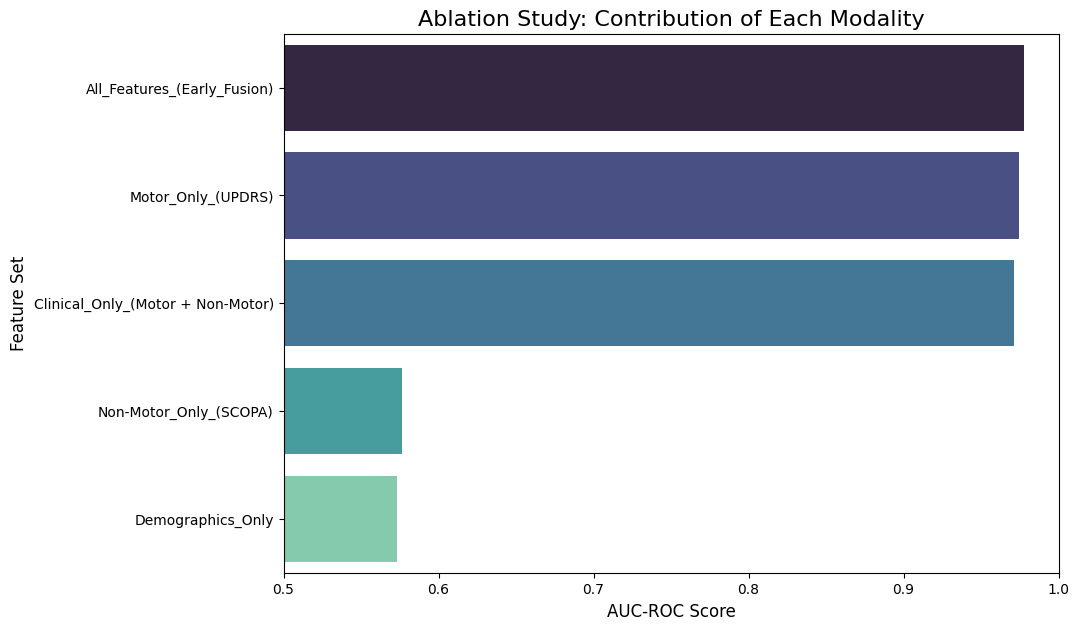

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

print("--- Performing Ablation Study ---")

# --- 1. Define Feature Subsets for the Study ---
# We will test each modality alone and in combination.
ablation_feature_sets = {
    "Demographics_Only": ['AGE', 'GENDER'],
    "Motor_Only_(UPDRS)": ['UPDRS_III_TOTAL'],
    "Non-Motor_Only_(SCOPA)": ['SCOPA_TOTAL'],
    "Clinical_Only_(Motor + Non-Motor)": ['UPDRS_III_TOTAL', 'SCOPA_TOTAL'],
    "All_Features_(Early_Fusion)": ['AGE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL']
}

# --- 2. Loop, Train, and Evaluate a Model for Each Subset ---
ablation_results = {}
for name, features in ablation_feature_sets.items():
    print(f"Training model for: {name}...")
    
    # Select the feature subset
    X_train_subset = X_train_scaled[features]
    X_test_subset = X_test_scaled[features]
    
    # Train a new RandomForest model
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_subset, y_train)
    
    # Predict probabilities and calculate AUC
    y_pred_proba = model.predict_proba(X_test_subset)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    ablation_results[name] = auc

# --- 3. Display the Results ---

# Create a DataFrame for a clean table view
results_df = pd.DataFrame.from_dict(ablation_results, orient='index', columns=['AUC_Score'])
results_df = results_df.sort_values(by='AUC_Score', ascending=False)

print("\n--- Ablation Study Results ---")
print(results_df)

# Create a bar plot to visualize the results
plt.figure(figsize=(10, 7))
sns.barplot(x=results_df['AUC_Score'], y=results_df.index, palette='mako')
plt.title('Ablation Study: Contribution of Each Modality', fontsize=16)
plt.xlabel('AUC-ROC Score', fontsize=12)
plt.ylabel('Feature Set', fontsize=12)
plt.xlim(0.5, 1.0) # Set x-axis limit to better visualize performance
plt.show()

In [11]:
!pip install xgboost lightgbm

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)

xgb_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)

y_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost AUC:", roc_auc_score(y_test, y_xgb))
print("LightGBM AUC:", roc_auc_score(y_test, y_lgbm))

[LightGBM] [Info] Number of positive: 420, number of negative: 287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 707, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [13]:
!pip install statsmodels

In [14]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score

# Example: Comparing RF and XGBoost predictions
from sklearn.metrics import confusion_matrix

rf_preds = model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)

# Create contingency table
table = confusion_matrix(rf_preds == y_test, xgb_preds == y_test)
result = mcnemar(table, exact=True)
print(f"McNemar’s Test p-value: {result.pvalue}")

McNemar’s Test p-value: 0.548828125


In [15]:
# Step 1: Confirm columns available
print(final_df.columns.tolist())
print(updrs_df.columns.tolist())
print(scopa_df.columns.tolist())
print(cohort_df.columns.tolist())
print(demog_df.columns.tolist())


['PATNO', 'COHORT', 'AGE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL']
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT', 'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF', 'PDMEDYN', 'DBSYN', 'ONOFFORDER', 'OFFEXAM', 'OFFNORSN', 'DBSOFFYN', 'DBSOFFTM', 'ONEXAM', 'ONNORSN', 'HIFUYN', 'DBSONYN', 'DBSONTM', 'PDMEDDT', 'PDMEDTM', 'EXAMDT', 'EXAMTM', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT', 'DYSKPRES', 'DYSKIRAT', 'NHY', 'ORIG_ENTRY', 'LAST_UPDATE']
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PTCGBOTH', 'SCAU1', 'SCAU2', 'SCAU3', 'SCAU4', 'SCAU5', 'SCAU6', 'SCAU7', 'SCAU8', 'SCAU9', 'SCAU10', 'SCAU11', 'SCAU12', 

In [16]:
!pip install shap

In [17]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


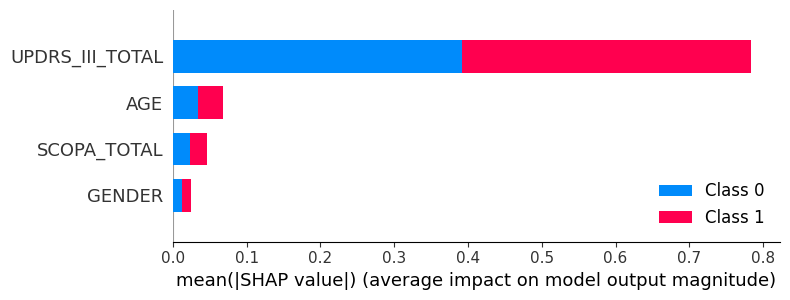

In [19]:
shap.summary_plot(shap_values, X_test)

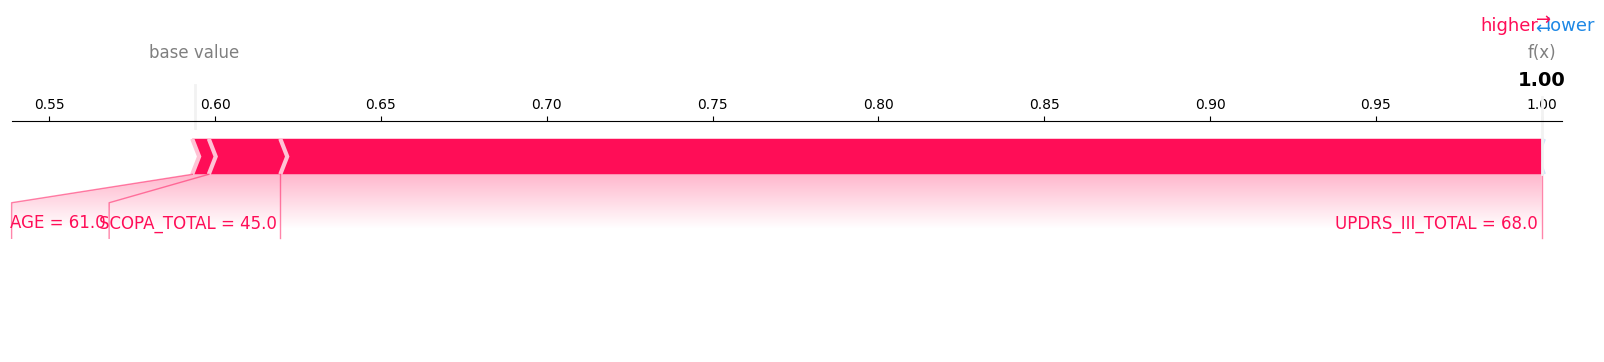

In [20]:
# Force plot for a single prediction
i = 0  # index of test sample
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[i], matplotlib=True)

In [22]:
print(final_df.columns)

Index(['PATNO', 'COHORT', 'AGE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL'], dtype='object')


In [27]:
# --- Data Sanity Check ---
# This code block will help you inspect the follow-up data for your prodromal cohort.

# Get the list of prodromal patients again
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == 4]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()

# Filter the demographics file for ONLY these patients
prodromal_followup_df = demog_df[demog_df['PATNO'].isin(prodromal_patno_list)]

print("--- Sanity Check for the Prodromal Cohort ---")
print("\nFollow-up visits available for this cohort:")
# We exclude the baseline ('BL') to only see follow-ups
print(prodromal_followup_df[prodromal_followup_df['EVENT_ID'] != 'BL']['EVENT_ID'].value_counts())

print("\nDiagnoses recorded at these follow-up visits:")
print(prodromal_followup_df[prodromal_followup_df['EVENT_ID'] != 'BL']['APPRDX'].value_counts())

--- Sanity Check for the Prodromal Cohort ---

Follow-up visits available for this cohort:
EVENT_ID
CONSENT    389
Name: count, dtype: int64

Diagnoses recorded at these follow-up visits:
APPRDX
6.0    353
4.0     36
Name: count, dtype: int64


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# --- Step 1: Load All Data Files ---
try:
    cohort_df = pd.read_csv(COHORT_HISTORY_FILE)
    demog_df = pd.read_csv("/kaggle/input/new-demographics/Demographics_24Jul2025.csv")
    updrs_df = pd.read_csv(UPDRS_FILE, low_memory=False)
    scopa_df = pd.read_csv(SCOPA_FILE)
    print("All data files loaded successfully for longitudinal analysis.")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Step 2: Create a Complete Baseline Dataset for the Prodromal Cohort ---
PRODROMAL_COHORT_ID = 4

# Get the definitive list of all patients in the prodromal cohort
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == PRODROMAL_COHORT_ID]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()
print(f"Identified {len(prodromal_patno_list)} participants in the overall prodromal cohort.")

# **FIX:** Create the 'AGE' column AFTER selecting the dataframe.
# Select the columns that exist in the original demog_df
demog_bl = demog_df[demog_df['EVENT_ID'] == 'BL'][['PATNO', 'GENDER', 'BIRTHDT']].copy()
# Now, create the 'AGE' column
demog_bl['AGE'] = 2025 - demog_bl['BIRTHDT']
demog_features = demog_bl[['PATNO', 'AGE', 'GENDER']]


# UPDRS Motor Score
updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL'].copy()
updrs_cols = [col for col in updrs_bl.columns if col.startswith('NP3')]
updrs_bl['UPDRS_III_TOTAL'] = updrs_bl[updrs_cols].sum(axis=1)
updrs_features = updrs_bl[['PATNO', 'UPDRS_III_TOTAL']]

# SCOPA-AUT Score
scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL'].copy()
scopa_cols = [col for col in scopa_bl.columns if col.startswith('SCAU')]
for col in scopa_cols:
    scopa_bl[col] = pd.to_numeric(scopa_bl[col], errors='coerce')
scopa_bl['SCOPA_TOTAL'] = scopa_bl[scopa_cols].sum(axis=1)
scopa_features = scopa_bl[['PATNO', 'SCOPA_TOTAL']]

# Merge all baseline features together
baseline_df = pd.merge(demog_features, updrs_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, scopa_features, on='PATNO', how='inner')

# Filter this complete baseline dataset to only include our prodromal patients
baseline_df = baseline_df[baseline_df['PATNO'].isin(prodromal_patno_list)]
baseline_df.dropna(inplace=True)
print(f"\nFound {len(baseline_df)} prodromal participants with a complete set of baseline data.")


# --- Step 3: Determine Conversion Status for this specific cohort ---
follow_up_visits = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08']
conversion_check_df = updrs_df[
    updrs_df['PATNO'].isin(baseline_df['PATNO']) &
    updrs_df['EVENT_ID'].isin(follow_up_visits)
]
converters_df = conversion_check_df.dropna(subset=['NHY'])
converters_patno = converters_df[converters_df['NHY'] > 0]['PATNO'].unique()

# Add the target variable to our complete baseline dataframe
baseline_df['Converted_to_PD'] = baseline_df['PATNO'].apply(lambda x: 1 if x in converters_patno else 0)
print(f"Found that {baseline_df['Converted_to_PD'].sum()} of these participants converted.")


# --- Step 4: Modeling and Evaluation ---
merged_df = baseline_df
print("\n--- Dataframe created and prepared for modeling ---")
print(f"Final dataset has {merged_df.shape[0]} participants.")
print("\nDistribution of Target Variable (Converted_to_PD):")
print(merged_df['Converted_to_PD'].value_counts())
print("-" * 50)

if not merged_df.empty and merged_df['Converted_to_PD'].nunique() > 1:
    features = ['AGE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL']
    target = 'Converted_to_PD'
    X = merged_df[features]
    y = merged_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("\n--- Model Performance (Predicting Conversion) ---")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("-" * 50)
    
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("\n--- Key Baseline Predictors of Conversion ---")
    print(feature_importance_df)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances for Predicting PD Conversion', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Baseline Feature', fontsize=12)
    plt.show()
else:
    print("\nCould not proceed with modeling. Check if there are enough converters in the dataset.")

All data files loaded successfully for longitudinal analysis.
Identified 389 participants in the overall prodromal cohort.


KeyError: "['GENDER'] not in index"

In [35]:
# --- Final Data Diagnostic Script ---

# 1. Get the list of prodromal patients
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == 4]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()
print(f"Total prodromal patients in cohort: {len(prodromal_patno_list)}")
print("-" * 50)

# 2. Check how many of them have each baseline assessment
demog_bl = demog_df[demog_df['EVENT_ID'] == 'BL']
prodromal_with_demog = demog_bl[demog_bl['PATNO'].isin(prodromal_patno_list)]
print(f"Prodromal patients with baseline Demographics: {len(prodromal_with_demog)}")

updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL']
prodromal_with_updrs = updrs_bl[updrs_bl['PATNO'].isin(prodromal_patno_list)]
print(f"Prodromal patients with baseline UPDRS-III: {len(prodromal_with_updrs)}")

scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL']
prodromal_with_scopa = scopa_bl[scopa_bl['PATNO'].isin(prodromal_patno_list)]
print(f"Prodromal patients with baseline SCOPA-AUT: {len(prodromal_with_scopa)}")
print("-" * 50)

# 3. Check the overlap between the two most likely features
demog_updrs_merged = pd.merge(prodromal_with_demog, prodromal_with_updrs, on='PATNO', how='inner')
print(f"Prodromal patients with both baseline Demographics AND UPDRS: {len(demog_updrs_merged)}")

Total prodromal patients in cohort: 389
--------------------------------------------------
Prodromal patients with baseline Demographics: 0
Prodromal patients with baseline UPDRS-III: 383
Prodromal patients with baseline SCOPA-AUT: 389
--------------------------------------------------
Prodromal patients with both baseline Demographics AND UPDRS: 0


All data files loaded successfully.
Identified 389 participants in the overall prodromal cohort.

Found 383 prodromal participants with complete baseline UPDRS and SCOPA scores.
Found 383 prodromal participants with complete baseline clinical and demographic data.
Of these, 62 converted to PD.

--- Dataframe created and prepared for modeling ---
Final dataset has 383 participants.

Distribution of Target Variable (Converted_to_PD):
Converted_to_PD
0    321
1     62
Name: count, dtype: int64
--------------------------------------------------


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



--- Model Performance (Predicting Conversion) ---
AUC-ROC Score: 0.5906
--------------------------------------------------

--- Key Baseline Predictors of Conversion ---
           Feature  Importance
3      SCOPA_TOTAL    0.346107
0  AGE_AT_BASELINE    0.340309
2  UPDRS_III_TOTAL    0.248085
1           GENDER    0.065498


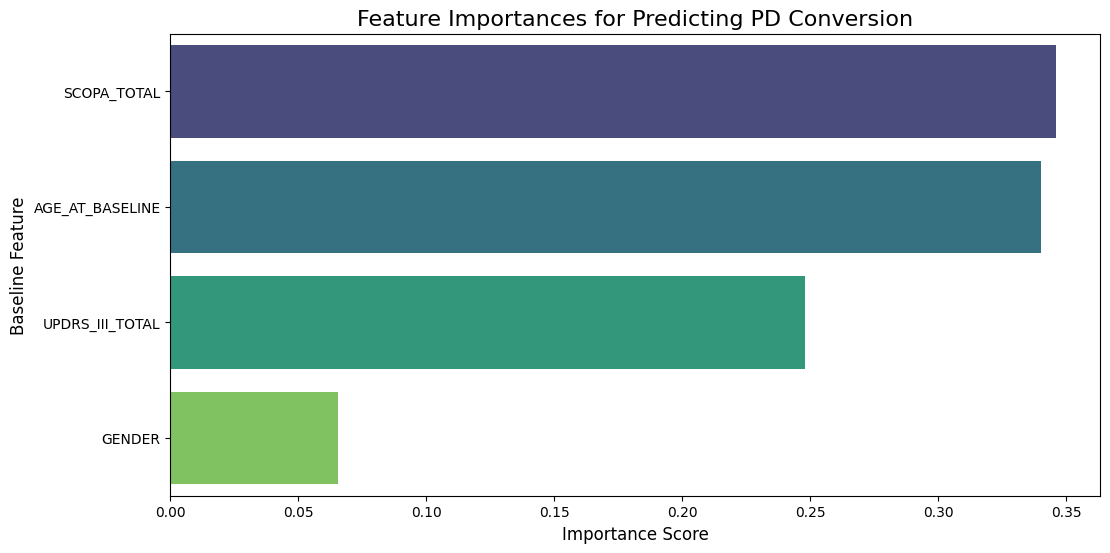

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# --- Step 1: Load All Data Files ---
try:
    cohort_df = pd.read_csv(COHORT_HISTORY_FILE)
    demog_df = pd.read_csv(DEMOGRAPHICS_FILE) # This is the Screening/Archived Demographics file
    updrs_df = pd.read_csv(UPDRS_FILE, low_memory=False)
    scopa_df = pd.read_csv(SCOPA_FILE)
    print("All data files loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Step 2: Create a Core Baseline Dataset ---
PRODROMAL_COHORT_ID = 4

# Get the definitive list of all patients in the prodromal cohort
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == PRODROMAL_COHORT_ID]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()
print(f"Identified {len(prodromal_patno_list)} participants in the overall prodromal cohort.")

# Get baseline clinical scores
updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL'].copy()
scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL'].copy()

# Engineer UPDRS & SCOPA scores
updrs_cols = [col for col in updrs_bl.columns if col.startswith('NP3')]
updrs_bl['UPDRS_III_TOTAL'] = updrs_bl[updrs_cols].sum(axis=1)
updrs_features = updrs_bl[['PATNO', 'UPDRS_III_TOTAL', 'INFODT']]

scopa_cols = [col for col in scopa_bl.columns if col.startswith('SCAU')]
for col in scopa_cols:
    scopa_bl[col] = pd.to_numeric(scopa_bl[col], errors='coerce')
scopa_bl['SCOPA_TOTAL'] = scopa_bl[scopa_cols].sum(axis=1)
scopa_features = scopa_bl[['PATNO', 'SCOPA_TOTAL']]

# Create the core clinical baseline by merging UPDRS and SCOPA
core_clinical_baseline = pd.merge(updrs_features, scopa_features, on='PATNO', how='inner')

# Filter this to only include patients from the prodromal cohort
prodromal_clinical_baseline = core_clinical_baseline[core_clinical_baseline['PATNO'].isin(prodromal_patno_list)]
print(f"\nFound {len(prodromal_clinical_baseline)} prodromal participants with complete baseline UPDRS and SCOPA scores.")

# --- Step 3: Get Static Demographics for this Core Group ---
# We use the screening file and drop duplicates to get one row per patient
demog_static = demog_df.drop_duplicates(subset=['PATNO'])[['PATNO', 'BIRTHDT', 'GENDER']]

# Merge the static demographics into our core clinical baseline
baseline_df = pd.merge(prodromal_clinical_baseline, demog_static, on='PATNO', how='inner')

# Engineer Age at Baseline
baseline_df['INFODT'] = pd.to_datetime(baseline_df['INFODT'], errors='coerce')
baseline_df['BIRTHDT'] = pd.to_datetime(baseline_df['BIRTHDT'], errors='coerce')
baseline_df['AGE_AT_BASELINE'] = (baseline_df['INFODT'] - baseline_df['BIRTHDT']).dt.days / 365.25
baseline_df.dropna(inplace=True)
print(f"Found {len(baseline_df)} prodromal participants with complete baseline clinical and demographic data.")


# --- Step 4: Determine Conversion Status for this Final Cohort ---
follow_up_visits = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08']
conversion_check_df = updrs_df[
    updrs_df['PATNO'].isin(baseline_df['PATNO']) &
    updrs_df['EVENT_ID'].isin(follow_up_visits)
]
converters_df = conversion_check_df.dropna(subset=['NHY'])
converters_patno = converters_df[converters_df['NHY'] > 0]['PATNO'].unique()

baseline_df['Converted_to_PD'] = baseline_df['PATNO'].apply(lambda x: 1 if x in converters_patno else 0)
print(f"Of these, {baseline_df['Converted_to_PD'].sum()} converted to PD.")


# --- Step 5: Modeling and Evaluation ---
merged_df = baseline_df
print("\n--- Dataframe created and prepared for modeling ---")
print(f"Final dataset has {merged_df.shape[0]} participants.")
print("\nDistribution of Target Variable (Converted_to_PD):")
print(merged_df['Converted_to_PD'].value_counts())
print("-" * 50)

if not merged_df.empty and merged_df['Converted_to_PD'].nunique() > 1:
    features = ['AGE_AT_BASELINE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL']
    target = 'Converted_to_PD'
    X = merged_df[features]
    y = merged_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("\n--- Model Performance (Predicting Conversion) ---")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("-" * 50)
    
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("\n--- Key Baseline Predictors of Conversion ---")
    print(feature_importance_df)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances for Predicting PD Conversion', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Baseline Feature', fontsize=12)
    plt.show()
else:
    print("\nCould not proceed with modeling. Check if there are enough converters or complete baseline data.")

In [42]:
# This script assumes 'cohort_df', 'demog_df', 'updrs_df', 'scopa_df', and 'datscan_df' are loaded.

print("--- Data Availability Report for the Prodromal Cohort ---")

# 1. Get the list of prodromal patients
try:
    prodromal_patients_df = cohort_df[cohort_df['COHORT'] == 4]
    prodromal_patno_list = prodromal_patients_df['PATNO'].unique()
    print(f"Total prodromal patients in master list: {len(prodromal_patno_list)}")
    print("-" * 50)
except Exception as e:
    print(f"Error getting prodromal list from cohort_df: {e}")


# 2. Count prodromal patients with each type of baseline data
try:
    # Demographics (using the static screening file)
    demog_static = demog_df.drop_duplicates(subset=['PATNO'])
    prodromal_with_demog = demog_static[demog_static['PATNO'].isin(prodromal_patno_list)]
    print(f"Prodromal patients with Demographics data: {len(prodromal_with_demog)}")

    # UPDRS
    updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL']
    prodromal_with_updrs = updrs_bl[updrs_bl['PATNO'].isin(prodromal_patno_list)]
    print(f"Prodromal patients with baseline UPDRS data: {len(prodromal_with_updrs)}")

    # SCOPA
    scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL']
    prodromal_with_scopa = scopa_bl[scopa_bl['PATNO'].isin(prodromal_patno_list)]
    print(f"Prodromal patients with baseline SCOPA data: {len(prodromal_with_scopa)}")

    # DaTscan
    datscan_bl = datscan_df[datscan_df['EVENT_ID'] == 'SC']
    prodromal_with_datscan = datscan_bl[datscan_bl['PATNO'].isin(prodromal_patno_list)]
    print(f"Prodromal patients with baseline DaTscan data: {len(prodromal_with_datscan)}")
    print("-" * 50)


    # 3. Check the overlap between combinations of datasets
    print("--- Overlap Analysis ---")
    
    # UPDRS + SCOPA
    updrs_scopa_merge = pd.merge(prodromal_with_updrs, prodromal_with_scopa, on='PATNO', how='inner')
    print(f"Patients with both UPDRS AND SCOPA: {len(updrs_scopa_merge)}")

    # UPDRS + DaTscan
    updrs_datscan_merge = pd.merge(prodromal_with_updrs, prodromal_with_datscan, on='PATNO', how='inner')
    print(f"Patients with both UPDRS AND DaTscan: {len(updrs_datscan_merge)}")

    # UPDRS + SCOPA + DaTscan
    clinical_merge = pd.merge(updrs_scopa_merge, prodromal_with_datscan, on='PATNO', how='inner')
    print(f"Patients with UPDRS AND SCOPA AND DaTscan: {len(clinical_merge)}")
    
    # ALL FOUR DATASETS
    final_merge = pd.merge(clinical_merge, prodromal_with_demog, on='PATNO', how='inner')
    print(f"Patients with ALL FOUR (Demographics, UPDRS, SCOPA, DaTscan): {len(final_merge)}")

except Exception as e:
    print(f"\nAn error occurred during the analysis: {e}")

--- Data Availability Report for the Prodromal Cohort ---
Total prodromal patients in master list: 389
--------------------------------------------------
Prodromal patients with Demographics data: 389
Prodromal patients with baseline UPDRS data: 383
Prodromal patients with baseline SCOPA data: 389
Prodromal patients with baseline DaTscan data: 397
--------------------------------------------------
--- Overlap Analysis ---
Patients with both UPDRS AND SCOPA: 383
Patients with both UPDRS AND DaTscan: 391
Patients with UPDRS AND SCOPA AND DaTscan: 391

An error occurred during the analysis: Passing 'suffixes' which cause duplicate columns {'PAG_NAME_x', 'LAST_UPDATE_x', 'REC_ID_x', 'ORIG_ENTRY_x', 'EVENT_ID_x'} is not allowed.


All data files loaded successfully.


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



--- Model Performance (Predicting Conversion with DaTscan) ---
AUC-ROC Score: 0.6177
--------------------------------------------------

--- Key Baseline Predictors of Conversion ---
           Feature  Importance
0  AGE_AT_BASELINE    0.347269
3      SCOPA_TOTAL    0.327068
2  UPDRS_III_TOTAL    0.248197
1           GENDER    0.059117
4          DATSCAN    0.018349


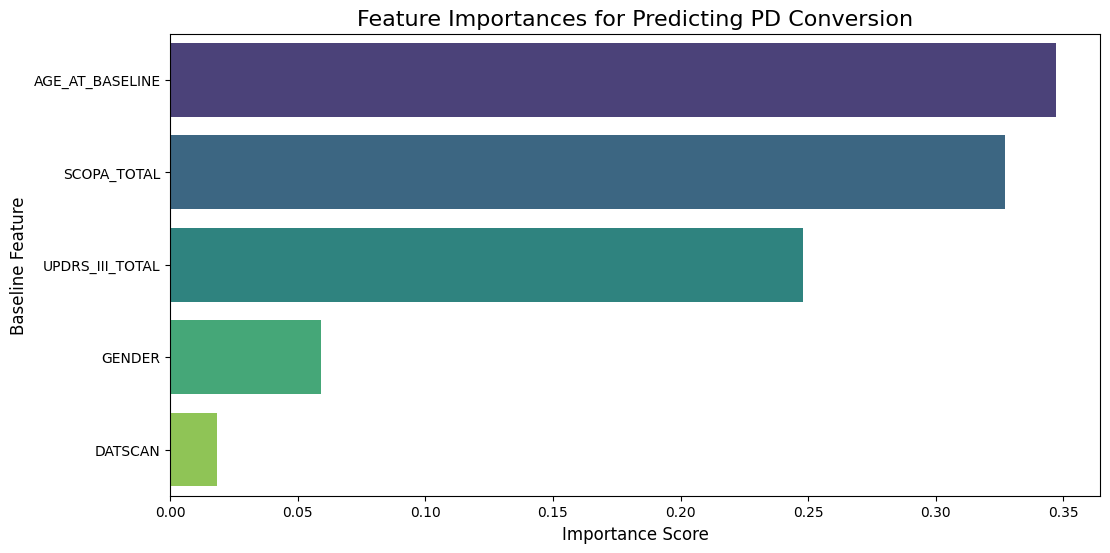

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# --- Step 1: Load All Data Files ---
# Ensure these paths point to your files
COHORT_HISTORY_FILE = "/kaggle/input/datasets-2/Subject_Cohort_History_24Jul2025.csv"
DEMOGRAPHICS_FILE = "/kaggle/input/datasets-2/Screening___Demographics-Archived_24Jun2025 (1).csv"
UPDRS_FILE = "/kaggle/input/datasets-2/MDS-UPDRS_Part_III_24Jun2025.csv"
SCOPA_FILE = "/kaggle/input/datasets-2/SCOPA-AUT_24Jul2025.csv"
DATSCAN_FILE = "/kaggle/input/datscan/DaTscan_Imaging_24Jul2025.csv" 

try:
    cohort_df = pd.read_csv(COHORT_HISTORY_FILE)
    demog_df = pd.read_csv(DEMOGRAPHICS_FILE) # Screening Demographics
    updrs_df = pd.read_csv(UPDRS_FILE, low_memory=False)
    scopa_df = pd.read_csv(SCOPA_FILE)
    datscan_df = pd.read_csv(DATSCAN_FILE)
    print("All data files loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Step 2: Prepare a Complete Baseline Dataset ---
PRODROMAL_COHORT_ID = 4

# Get the list of all patients in the prodromal cohort
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == PRODROMAL_COHORT_ID]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()

# Get static demographics
demog_static = demog_df.drop_duplicates(subset=['PATNO'])[['PATNO', 'BIRTHDT', 'GENDER']]

# Get baseline clinical scores using 'SC' for the event ID
updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL'].copy()
scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL'].copy()
datscan_bl = datscan_df[datscan_df['EVENT_ID'] == 'SC'].copy()

# Engineer features
updrs_cols = [col for col in updrs_bl.columns if col.startswith('NP3')]
updrs_bl['UPDRS_III_TOTAL'] = updrs_bl[updrs_cols].sum(axis=1)
updrs_features = updrs_bl[['PATNO', 'UPDRS_III_TOTAL', 'INFODT']]

scopa_cols = [col for col in scopa_bl.columns if col.startswith('SCAU')]
for col in scopa_cols:
    scopa_bl[col] = pd.to_numeric(scopa_bl[col], errors='coerce')
scopa_bl['SCOPA_TOTAL'] = scopa_bl[scopa_cols].sum(axis=1)
scopa_features = scopa_bl[['PATNO', 'SCOPA_TOTAL']]

datscan_features = datscan_bl[['PATNO', 'DATSCAN']]

# Merge all baseline features together
baseline_df = pd.merge(demog_static, updrs_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, scopa_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, datscan_features, on='PATNO', how='inner')

# Filter for the prodromal cohort
baseline_df = baseline_df[baseline_df['PATNO'].isin(prodromal_patno_list)]

# Engineer Age and drop rows missing ANY required data
baseline_df['INFODT'] = pd.to_datetime(baseline_df['INFODT'], errors='coerce')
baseline_df['BIRTHDT'] = pd.to_datetime(baseline_df['BIRTHDT'], errors='coerce')
baseline_df['AGE_AT_BASELINE'] = (baseline_df['INFODT'] - baseline_df['BIRTHDT']).dt.days / 365.25
baseline_df.dropna(inplace=True)

# --- Step 3: Determine Conversion Status for this Final Cohort ---
follow_up_visits = ['V04', 'V06', 'V08', 'V10', 'V12']
conversion_check_df = updrs_df[
    updrs_df['PATNO'].isin(baseline_df['PATNO']) &
    updrs_df['EVENT_ID'].isin(follow_up_visits)
]
converters_df = conversion_check_df.dropna(subset=['NHY'])
converters_patno = converters_df[converters_df['NHY'] > 0]['PATNO'].unique()

baseline_df['Converted_to_PD'] = baseline_df['PATNO'].apply(lambda x: 1 if x in converters_patno else 0)

# --- Step 4: Modeling and Evaluation ---
merged_df = baseline_df

if not merged_df.empty and merged_df['Converted_to_PD'].nunique() > 1:
    features = ['AGE_AT_BASELINE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL', 'DATSCAN']
    target = 'Converted_to_PD'
    X = merged_df[features]
    y = merged_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("\n--- Model Performance (Predicting Conversion with DaTscan) ---")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("-" * 50)
    
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("\n--- Key Baseline Predictors of Conversion ---")
    print(feature_importance_df)
    
    # --- Code to Generate the Plot ---
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances for Predicting PD Conversion', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Baseline Feature', fontsize=12)
    plt.show()
else:
    print("\nCould not proceed with modeling.")

An error occurred: [Errno 2] No such file or directory: '/kaggle/input/datasets-2/Genetics.csv'

Found 391 prodromal participants with a complete set of all baseline data.
Of these, 72 converted to PD.

--- Dataframe created and prepared for modeling ---
Final dataset has 391 participants.

Distribution of Target Variable (Converted_to_PD):
Converted_to_PD
0    319
1     72
Name: count, dtype: int64
--------------------------------------------------


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



--- Model Performance (with Genetics and DaTscan) ---
AUC-ROC Score: 0.6674
--------------------------------------------------

--- Key Baseline Predictors of Conversion ---
           Feature  Importance
0  AGE_AT_BASELINE    0.329021
2      SCOPA_TOTAL    0.309632
1  UPDRS_III_TOTAL    0.232829
6    PATHVAR_COUNT    0.061900
8       GENDER_2.0    0.027074
7       GENDER_1.0    0.022012
3          DATSCAN    0.015815
4     GBA_Mutation    0.001717
5   LRRK2_Mutation    0.000000


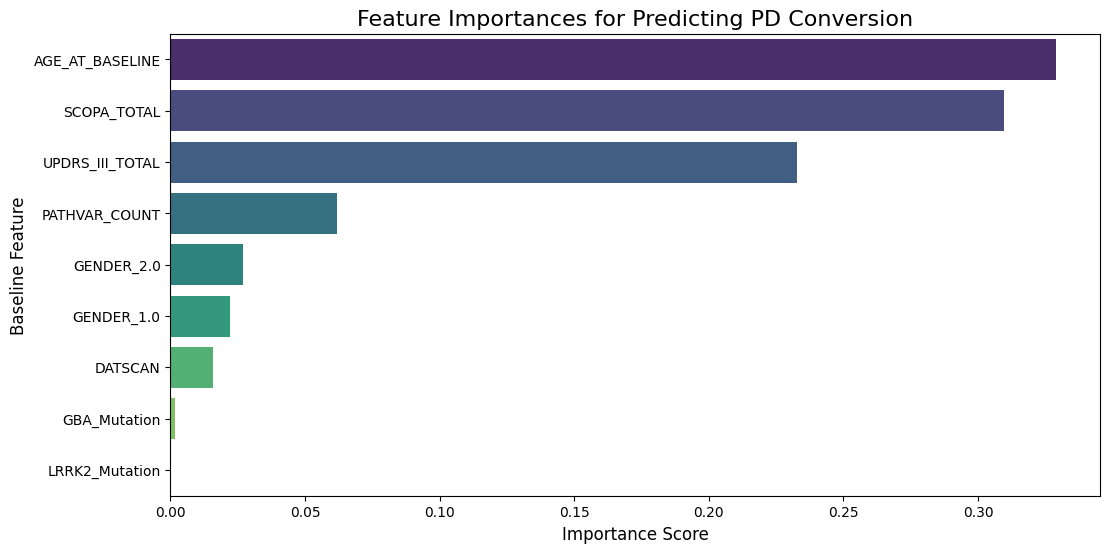

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# --- Step 1: Load All Data Files ---
# Ensure these paths point to your specific files
COHORT_HISTORY_FILE = "/kaggle/input/datasets-2/Subject_Cohort_History_24Jul2025.csv"
DEMOGRAPHICS_FILE = "/kaggle/input/datasets-2/Screening___Demographics-Archived_24Jun2025 (1).csv"
UPDRS_FILE = "/kaggle/input/datasets-2/MDS-UPDRS_Part_III_24Jun2025.csv"
SCOPA_FILE = "/kaggle/input/datasets-2/SCOPA-AUT_24Jul2025.csv"
DATSCAN_FILE = "/kaggle/input/datscan/DaTscan_Imaging_24Jul2025.csv"
GENETICS_FILE = "/kaggle/input/datasets-2/Genetics.csv" # <-- New Genetics File

try:
    cohort_df = pd.read_csv(COHORT_HISTORY_FILE)
    demog_df = pd.read_csv(DEMOGRAPHICS_FILE) # Screening Demographics
    updrs_df = pd.read_csv(UPDRS_FILE, low_memory=False)
    scopa_df = pd.read_csv(SCOPA_FILE)
    datscan_df = pd.read_csv(DATSCAN_FILE)
    genetics_df = pd.read_csv(GENETICS_FILE) # NEW: Load genetic data
    print("All data files loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Step 2: Prepare a Complete Baseline Dataset ---
PRODROMAL_COHORT_ID = 4

# Get the definitive list of all patients in the prodromal cohort
prodromal_patients_df = cohort_df[cohort_df['COHORT'] == PRODROMAL_COHORT_ID]
prodromal_patno_list = prodromal_patients_df['PATNO'].unique()

# Get static demographics (no EVENT_ID needed)
demog_static = demog_df.drop_duplicates(subset=['PATNO'])[['PATNO', 'BIRTHDT', 'GENDER']]

# Get genetic data and pre-process it to be numeric
genetics_df['GBA_Mutation'] = genetics_df['GBA'].notna().astype(int)
genetics_df['LRRK2_Mutation'] = genetics_df['LRRK2'].notna().astype(int)
genetics_features = genetics_df[['PATNO', 'GBA_Mutation', 'LRRK2_Mutation', 'PATHVAR_COUNT']]

# Get baseline clinical scores using 'BL' for the event ID
updrs_bl = updrs_df[updrs_df['EVENT_ID'] == 'BL'].copy()
scopa_bl = scopa_df[scopa_df['EVENT_ID'] == 'BL'].copy()

# Get baseline DaTscan data using 'SC' for the event ID
datscan_bl = datscan_df[datscan_df['EVENT_ID'] == 'SC'].copy()

# Engineer features
updrs_cols = [col for col in updrs_bl.columns if col.startswith('NP3')]
updrs_bl['UPDRS_III_TOTAL'] = updrs_bl[updrs_cols].sum(axis=1)
updrs_features = updrs_bl[['PATNO', 'UPDRS_III_TOTAL', 'INFODT']]

scopa_cols = [col for col in scopa_bl.columns if col.startswith('SCAU')]
for col in scopa_cols:
    scopa_bl[col] = pd.to_numeric(scopa_bl[col], errors='coerce')
scopa_bl['SCOPA_TOTAL'] = scopa_bl[scopa_cols].sum(axis=1)
scopa_features = scopa_bl[['PATNO', 'SCOPA_TOTAL']]

datscan_features = datscan_bl[['PATNO', 'DATSCAN']]

# Merge all baseline features together using the correct logic
baseline_df = pd.merge(demog_static, updrs_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, scopa_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, datscan_features, on='PATNO', how='inner')
baseline_df = pd.merge(baseline_df, genetics_features, on='PATNO', how='inner') # NEW: Merge genetics

# Filter for the prodromal cohort
baseline_df = baseline_df[baseline_df['PATNO'].isin(prodromal_patno_list)]

# Engineer Age and drop rows missing ANY required data
baseline_df['INFODT'] = pd.to_datetime(baseline_df['INFODT'], errors='coerce')
baseline_df['BIRTHDT'] = pd.to_datetime(baseline_df['BIRTHDT'], errors='coerce')
baseline_df['AGE_AT_BASELINE'] = (baseline_df['INFODT'] - baseline_df['BIRTHDT']).dt.days / 365.25
baseline_df.dropna(inplace=True)
print(f"\nFound {len(baseline_df)} prodromal participants with a complete set of all baseline data.")


# --- Step 3: Determine Conversion Status for this Final Cohort ---
follow_up_visits = ['V04', 'V06', 'V08', 'V10', 'V12']
conversion_check_df = updrs_df[
    updrs_df['PATNO'].isin(baseline_df['PATNO']) &
    updrs_df['EVENT_ID'].isin(follow_up_visits)
]
converters_df = conversion_check_df.dropna(subset=['NHY'])
converters_patno = converters_df[converters_df['NHY'] > 0]['PATNO'].unique()

baseline_df['Converted_to_PD'] = baseline_df['PATNO'].apply(lambda x: 1 if x in converters_patno else 0)
print(f"Of these, {baseline_df['Converted_to_PD'].sum()} converted to PD.")


# --- Step 4: Modeling and Evaluation ---
merged_df = baseline_df
print("\n--- Dataframe created and prepared for modeling ---")
print(f"Final dataset has {merged_df.shape[0]} participants.")
print("\nDistribution of Target Variable (Converted_to_PD):")
print(merged_df['Converted_to_PD'].value_counts())
print("-" * 50)

if not merged_df.empty and merged_df['Converted_to_PD'].nunique() > 1:
    # Add the new numeric genetic features
    features = ['AGE_AT_BASELINE', 'GENDER', 'UPDRS_III_TOTAL', 'SCOPA_TOTAL', 'DATSCAN', 'GBA_Mutation', 'LRRK2_Mutation', 'PATHVAR_COUNT']
    target = 'Converted_to_PD'
    
    X_pre = merged_df[features]
    X = pd.get_dummies(X_pre, columns=['GENDER'], drop_first=True)
    y = merged_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("\n--- Model Performance (with Genetics and DaTscan) ---")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("-" * 50)
    
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("\n--- Key Baseline Predictors of Conversion ---")
    print(feature_importance_df)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Feature Importances for Predicting PD Conversion', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Baseline Feature', fontsize=12)
    plt.show()
else:
    print("\nCould not proceed with modeling. Check final dataframe and converter counts.")